In [1]:
import os, sys

# Get the absolute path of the notebook's directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add the parent directory to sys.path so we can import modules
sys.path.append(parent_dir)

# Verify the path
print(f"Added to sys.path: {parent_dir}")

# Add it to sys.path
sys.path.append(parent_dir)

print(parent_dir)
from localityaware.module import *
from NSGA_nn.nsga import optimize_surr_nsga_1
from FlashOperation.Refrig2DrumHeatExConstrDummy import Refrig2DrumConstraintHeatExConstDummy

Added to sys.path: /Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen
/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen
['/Users/panwapromtep/miniforge3/envs/torch/lib/python312.zip', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/lib-dynload', '', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/site-packages', '/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen', '/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen', '/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen']


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pickle
import os

# Define the file path for saving/loading the data
data_file = "flash_simulation_data_sim_new.pkl"

# Define parameter ranges
flash_1_range_sim = np.linspace(-15, 15, 10)
flash_2_range_sim = np.linspace(-15, 15, 10)

print("Generating new data...")
assSim = Refrig2DrumConstraintHeatExConstDummy(AspenFile="../FlashOperation/FlashOperation_HeatExchanger.bkp",
                                        wdpath="../FlashOperation",
                                        visibility=False,
                                        Penalty=1e3)
data_sim = []
for flash_1 in flash_1_range_sim:
    for flash_2 in flash_2_range_sim:
        x_unflat = assSim.unflatten_params([float(flash_1), float(flash_2)])
        data_sim.append([flash_1, flash_2, assSim.run_obj(x_unflat)])

data_sim = np.array(data_sim)

Generating new data...
⚠️ Dummy Mode: Skipping Aspen simulation initialization.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

def plot_contour_surface(data, x_label, y_label, z_label, x_point=None, gradient=None):
    """
    Generate a high-resolution heatmap with contour lines based on the given 3D data.
    Optionally overlays a single point (x_point) and its gradient vector on the plot.
    """
    # Convert data to numpy array for easier manipulation
    data = np.array(data)
    x, y, z = data[:, 0], data[:, 1], data[:, 2]

    # Generate a finer grid for interpolation
    grid_x, grid_y = np.meshgrid(
        np.linspace(x.min(), x.max(), 200),
        np.linspace(y.min(), y.max(), 200)
    )
    
    # Interpolate z values using cubic interpolation
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

    # Create the heatmap and add contour lines
    plt.figure(figsize=(8, 6))
    plt.imshow(grid_z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(label=z_label)

    contour_levels = np.linspace(np.nanmin(grid_z), np.nanmax(grid_z), 15)
    plt.contour(grid_x, grid_y, grid_z, levels=contour_levels, colors='black', linewidths=0.8)
    
    # Plot the true optimal point
    true_optimal = np.array([-1.11, -0.5])
    plt.scatter(true_optimal[0], true_optimal[1], color='blue', zorder=5)
    plt.text(true_optimal[0], true_optimal[1], 'True Optimal', color='white', fontsize=10, ha='right')
    
    # Plot the local minimum points
    local_minima = [np.array([0.84, -0.5]), np.array([0.27, -0.5])]
    for lm in local_minima:
        plt.scatter(lm[0], lm[1], color='orange', zorder=5)
        plt.text(lm[0], lm[1], 'Local Min', color='orange', fontsize=10, ha='right')
    
    # Overlay the x point and gradient arrow if provided
    if x_point is not None and gradient is not None:
        # Convert the x and grad lists to NumPy arrays with float type
        gradient = np.asarray(gradient, dtype=float) # grad is grad_pred.tolist() passed in
        plt.quiver(
            x_point[0], x_point[1],
            gradient[0], gradient[1],
            color='red', angles='xy', scale_units='xy', scale=0.1, zorder=10
        )
        plt.scatter(x_point[0], x_point[1], color='red', zorder=10)  # Mark the point
        plt.text(x_point[0], x_point[1], 'x_point', color='red', fontsize=10, ha='left')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

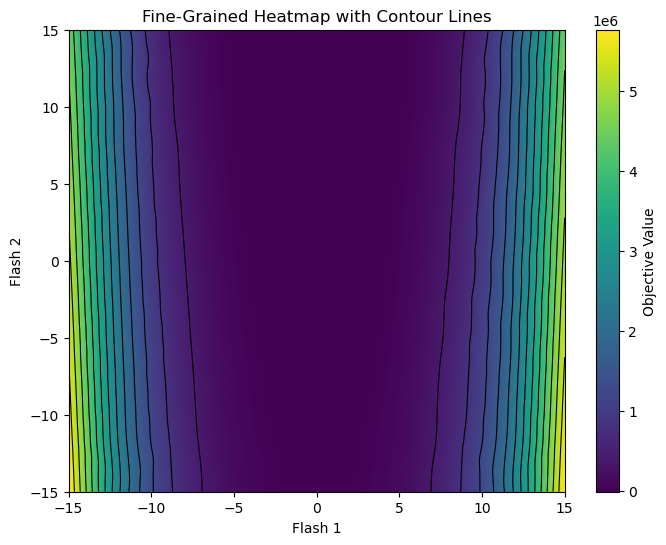

In [5]:
# Extract columns
x, y, z = data_sim[:, 0], data_sim[:, 1], data_sim[:, 2]

# Generate a finer grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 200),  # Increased resolution
    np.linspace(y.min(), y.max(), 200)
)

# Interpolate z values using cubic interpolation
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Create a high-resolution heatmap with contour lines
plt.figure(figsize=(8, 6))
plt.imshow(grid_z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Objective Value')

# Add contour lines
contour_levels = np.linspace(grid_z.min(), grid_z.max(), 15)  # Define contour levels
plt.contour(grid_x, grid_y, grid_z, levels=contour_levels, colors='black', linewidths=0.8)

# Add labels and title
plt.xlabel('Flash 1')
plt.ylabel('Flash 2')
plt.title('Fine-Grained Heatmap with Contour Lines')

# Show the plot
plt.show()


In [6]:
print(len(data_sim))
scaler = TorchMinMaxScaler((-1, 1), 
                           max_vals=[15.0, 15.0],
                           min_vals=[-15.0, -15.0],
                           min_y=0,
                           max_y=1e6 ,
                           scale_y=True)
#scale data_sim 
data_sim_xscaled, data_sim_yscaled = scaler.transform(data_sim[:, :2], data_sim[:, 2])

#recombine the data
data_sim_scaled = np.column_stack([data_sim_xscaled, data_sim_yscaled])
print(data_sim_scaled)

# **Initialize Model & Datasets**
dataset = OldDataSet(data_sim_scaled)
model = MLP(2, [20,20,20, 40,40], 1)

100
[[-1.         -1.         10.520578  ]
 [-1.         -0.7777778  10.2028    ]
 [-1.         -0.5555555   9.889467  ]
 [-1.         -0.3333333   9.580578  ]
 [-1.         -0.1111111   9.276134  ]
 [-1.          0.11111104  8.976134  ]
 [-1.          0.33333337  8.680578  ]
 [-1.          0.55555546  8.389467  ]
 [-1.          0.7777779   8.1028    ]
 [-1.          1.          7.8205776 ]
 [-0.7777778  -1.          3.567287  ]
 [-0.7777778  -0.7777778   3.3680282 ]
 [-0.7777778  -0.5555555   3.173213  ]
 [-0.7777778  -0.3333333   2.9828427 ]
 [-0.7777778  -0.1111111   2.7969167 ]
 [-0.7777778   0.11111104  2.6154354 ]
 [-0.7777778   0.33333337  2.4383984 ]
 [-0.7777778   0.55555546  2.2658057 ]
 [-0.7777778   0.7777779   2.0976574 ]
 [-0.7777778   1.          1.9339538 ]
 [-0.5555555  -1.          0.42638636]
 [-0.5555555  -0.7777778   0.31601596]
 [-0.5555555  -0.5555555   0.21009016]
 [-0.5555555  -0.3333333   0.1086086 ]
 [-0.5555555  -0.1111111   0.01157153]
 [-0.5555555   0.1111

In [7]:
out = optimize_surr_nsga_1(model=model,
                   old_dataset=dataset,
                   assSim=assSim,
                   lr=1e-4, 
                   epoch=1000,
                   min_vals=scaler.min_x,
                   max_vals=scaler.max_x,
                   scaler=scaler,
                   device='cpu',
                   iter=10,
                   print_loss=True,
                   print_it_data=True,
                   lambda_mse=1,
                   pop_size=100,
                   n_gen = 3,
                   new_data_size=20
                   )

Iteration 0: Training surrogate model...
device cpu
Epoch 0: Total Loss=28.1999
Epoch 10: Total Loss=28.1352
Epoch 20: Total Loss=28.0697
Epoch 30: Total Loss=28.0025
Epoch 40: Total Loss=27.9325
Epoch 50: Total Loss=27.8587
Epoch 60: Total Loss=27.7800
Epoch 70: Total Loss=27.6958
Epoch 80: Total Loss=27.6052
Epoch 90: Total Loss=27.5073
Epoch 100: Total Loss=27.4013
Epoch 110: Total Loss=27.2864
Epoch 120: Total Loss=27.1618
Epoch 130: Total Loss=27.0267
Epoch 140: Total Loss=26.8801
Epoch 150: Total Loss=26.7212
Epoch 160: Total Loss=26.5489
Epoch 170: Total Loss=26.3622
Epoch 180: Total Loss=26.1601
Epoch 190: Total Loss=25.9415
Epoch 200: Total Loss=25.7054
Epoch 210: Total Loss=25.4510
Epoch 220: Total Loss=25.1772
Epoch 230: Total Loss=24.8837
Epoch 240: Total Loss=24.5700
Epoch 250: Total Loss=24.2363
Epoch 260: Total Loss=23.8831
Epoch 270: Total Loss=23.5113
Epoch 280: Total Loss=23.1224
Epoch 290: Total Loss=22.7183
Epoch 300: Total Loss=22.3015
Epoch 310: Total Loss=21.8745

In [8]:
def func(x):
    x1,x2 = x
    # cost_value = (2 - x1)**2 + 100 * (x2 - x1**2)**2
    cost_value = (x1)**2 + (x2)**2
    return cost_value

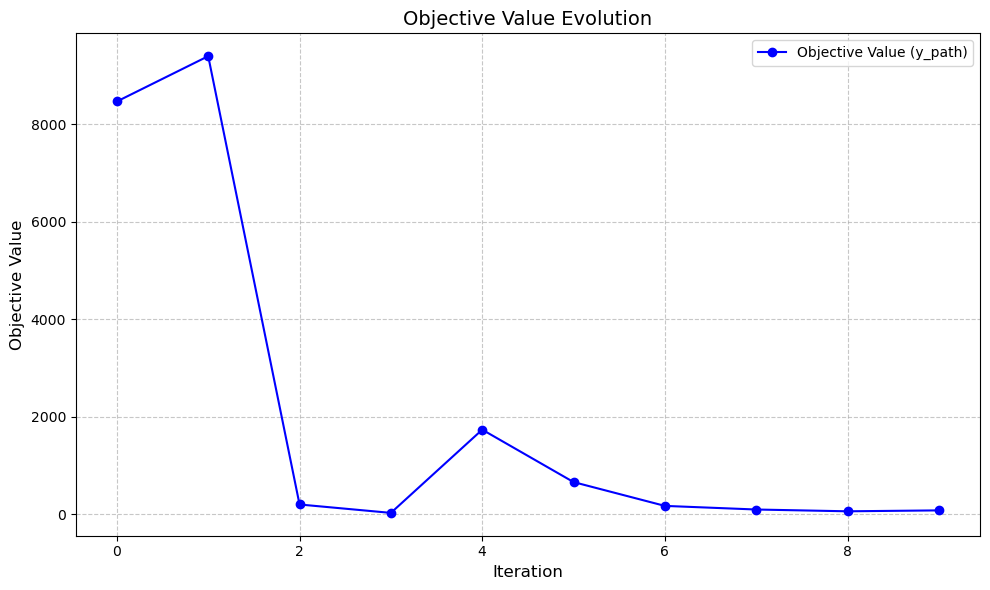

Objective Value Path (y_path): [8464.987284499926, 9394.642559857297, 195.44363222817526, 23.072019449811677, 1730.6010298078634, 655.1886948544039, 166.60779144501214, 92.27541008339372, 55.66388882903418, 74.44172701559772]
Decision Variable Path (x_path): [array([-2.3980627, 14.940723 ], dtype=float32), array([-0.09519768,  9.699394  ], dtype=float32), array([-0.40188122,  1.5387325 ], dtype=float32), array([-0.4089327 ,  0.58278656], dtype=float32), array([-0.21016121, -4.1100063 ], dtype=float32), array([ 0.0925951, -2.5439749], dtype=float32), array([ 0.18762016, -1.2427778 ], dtype=float32), array([ 0.23631859, -0.8884249 ], dtype=float32), array([ 0.27025032, -0.65271854], dtype=float32), array([ 0.1885128, -0.8080282], dtype=float32)]


In [19]:
plt.figure(figsize=(10, 6))
plt.plot(out['y_path'], marker='o', label='Objective Value (y_path)', color='blue')
plt.title('Objective Value Evolution', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Objective Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("Objective Value Path (y_path):", out['y_path'])
print("Decision Variable Path (x_path):", out['x_path'])

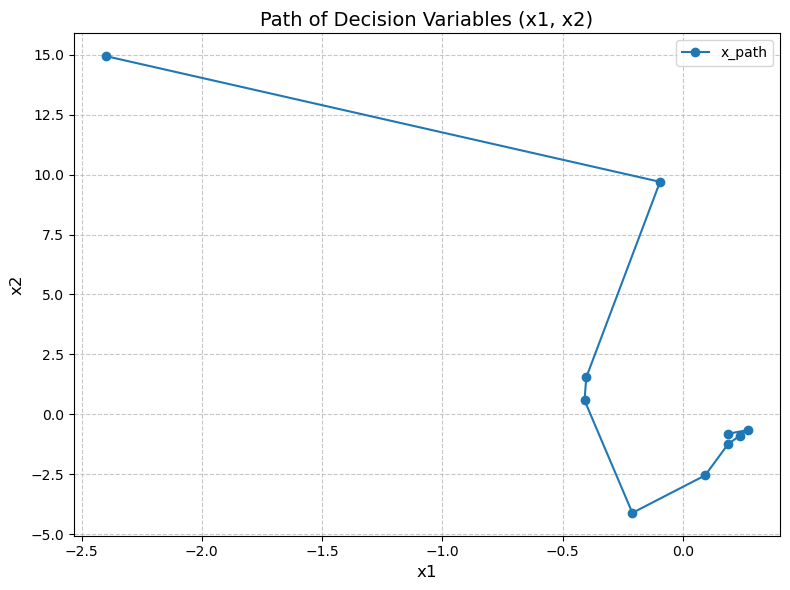

In [20]:
# Plot x_path for x1 and x2
x_path_array = np.array(out['x_path'])  # Convert the list of arrays to a NumPy array
plt.figure(figsize=(8, 6))
plt.plot(x_path_array[:, 0], x_path_array[:, 1], marker='o', label='x_path')
plt.title('Path of Decision Variables (x1, x2)', fontsize=14)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [11]:
x = [2,4]
input_tensor = torch.tensor(np.array(x), dtype=torch.float32)
input_tensor_scaled = scaler.transform(input_tensor)
print("input tensor scaled:",input_tensor_scaled)
print("expected out:", func(x))
output_scaled = model(input_tensor_scaled)
input, output = scaler.inverse_transform(input_tensor_scaled, output_scaled)
print("unscaled in out", input,output)


input tensor scaled: tensor([0.1333, 0.2667])
expected out: 20
unscaled in out tensor([2., 4.]) tensor([[448.0183]], grad_fn=<AddBackward0>)


In [12]:
out['populations']

[array([[ 3.95898505e-01, -7.20908305e-01],
        [-8.75574900e-01, -5.35130272e-01],
        [ 6.38765092e-01, -1.33164516e-01],
        [-9.02315508e-01, -3.19489101e-01],
        [-7.97769721e-01,  5.14233150e-01],
        [-1.14153806e-01, -2.82036614e-01],
        [ 8.21031237e-01, -8.44230919e-01],
        [ 1.73525734e-01,  3.81654897e-01],
        [-7.27262687e-01,  6.16975190e-01],
        [ 6.08124597e-01,  3.44600646e-01],
        [-5.10731569e-01, -6.75172560e-01],
        [-6.89056152e-01, -8.18299327e-01],
        [ 7.78081416e-01, -4.07664106e-01],
        [ 2.19757022e-01, -8.26671431e-01],
        [ 9.61270792e-01, -5.45876794e-01],
        [-3.17089129e-01, -5.07463060e-01],
        [ 7.11814078e-01,  2.56664860e-01],
        [ 5.64819231e-01,  2.32521422e-02],
        [-2.58849483e-01,  5.81324942e-02],
        [-9.23373371e-01,  2.99653838e-01],
        [ 2.39368255e-01, -3.88235699e-01],
        [-8.44010633e-01,  2.71662985e-01],
        [ 3.37900547e-01, -4.616

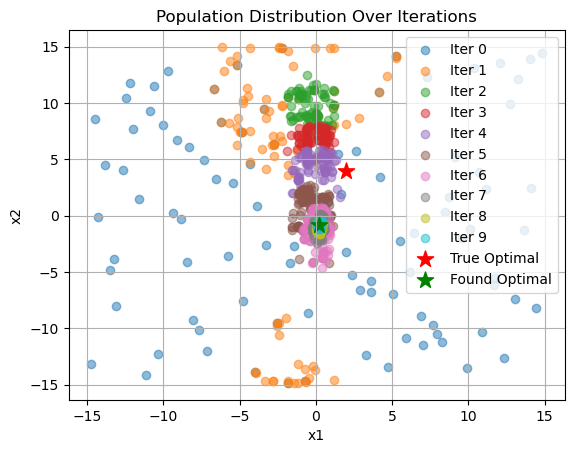

In [22]:
import matplotlib.pyplot as plt

def plot_population_evolution(all_pops, min, scaler):
    for i, pop in enumerate(all_pops):
        # Inverse transform the scaled population
        pop = scaler.inverse_transform(pop)
        # Extract x1 and x2 coordinates
        x = pop[:, 0]
        y = pop[:, 1]
        plt.scatter(x, y, alpha=0.5, label=f'Iter {i}')
    
    plt.title("Population Distribution Over Iterations")
    plt.xlabel("x1")
    plt.ylabel("x2")
    #plot the true minimum point
    plt.scatter(min[0], min[1], color='red', marker='*', s=150, label='True Optimal')
    #plot the minimum point found by the model
    plt.scatter(out['x_path'][-1][0], out['x_path'][-1][1], color='green', marker='*', s=150, label='Found Optimal')
    

    plt.legend()
    plt.grid(True)
    plt.show()

plot_population_evolution(out['populations'], [2,4], scaler)


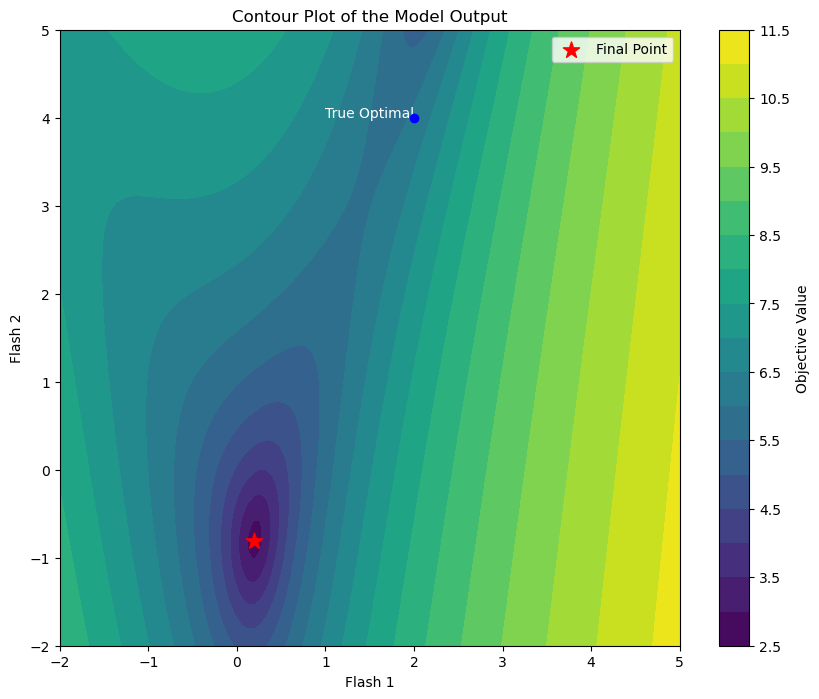

In [17]:
#plot contour surface of the model
x = np.linspace(-2, 5, 100)
y = np.linspace(-2, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        input_tensor = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)
        input_tensor_scaled = scaler.transform(input_tensor)
        output_scaled = model(input_tensor_scaled)
        input, output = scaler.inverse_transform(input_tensor_scaled, output_scaled)
        Z[i, j] = output.item()
#log transform Z
Z = np.log(Z + 1e-10)  # Adding a small constant to avoid log(0)
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.title('Contour Plot of the Model Output')
plt.xlabel('Flash 1')
plt.ylabel('Flash 2')
plt.scatter(out['x_path'][-1][0], out['x_path'][-1][1], color='red', marker='*', s=150, label='Final Point')
#plot the true optimal point
true_optimal = np.array([2, 4])
plt.scatter(true_optimal[0], true_optimal[1], color='blue', zorder=5)
plt.text(true_optimal[0], true_optimal[1], 'True Optimal', color='white', fontsize=10, ha='right')
plt.legend()
plt.show()

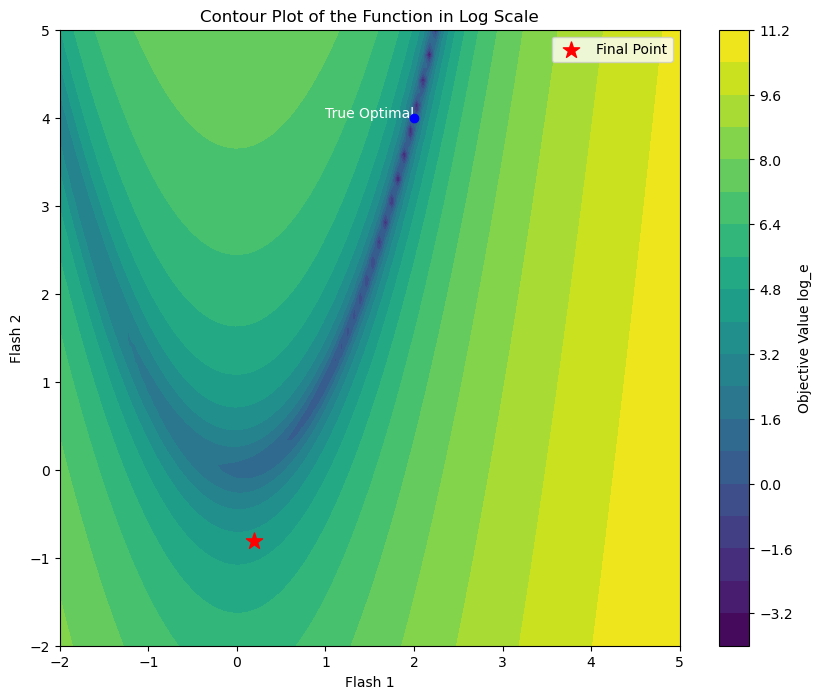

In [21]:
#rosenbrock function
def rosenbrock(x):
    x1, x2 = x
    return (2 - x1)**2 + 100 * (x2 - x1**2)**2

# Generate a grid of points
x = np.linspace(-2, 5, 100)
y = np.linspace(-2, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = rosenbrock([X[i, j], Y[i, j]])

#log scale the Z values
Z = np.log(Z + 1e-10)  # Adding a small constant to avoid log(0)

plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Objective Value log_e')
plt.title('Contour Plot of the Function in Log Scale')
plt.xlabel('Flash 1')
plt.ylabel('Flash 2')
plt.scatter(out['x_path'][-1][0], out['x_path'][-1][1], color='red', marker='*', s=150, label='Final Point')
#plot the true optimal point
true_optimal = np.array([2, 4])
plt.scatter(true_optimal[0], true_optimal[1], color='blue', zorder=5)
plt.text(true_optimal[0], true_optimal[1], 'True Optimal', color='white', fontsize=10, ha='right')
plt.legend()
plt.show()

In [16]:
x1, x2 = 0.27312183, 0.5264797
result = rosenbrock([x1, x2])
print("Rosenbrock function result:", result)
#compare to 2,4
print("True optimal:", rosenbrock([2, 4]))

Rosenbrock function result: 23.402038160136204
True optimal: 0
